# Natural Gas Price Analysis and Forecasting

## Data Import and Preprocessing

The analysis begins with importing essential libraries:

- `pandas` for data manipulation  
- `numpy` for numerical operations  
- `matplotlib` and `seaborn` for visualization  
- `statsmodels` for time series analysis  
- `pmdarima` for ARIMA modeling  


In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/natural-gas/Nat_Gas.csv


In [47]:
from pmdarima import auto_arima

In [48]:
# Load data with proper date formatting
data = pd.read_csv('../input/natural-gas/Nat_Gas.csv', parse_dates=['Dates'], 
                 date_format=lambda x: pd.to_datetime(x, format='%m/%d/%y'))

In [49]:
data['Prices'] = data['Prices'].apply(lambda x: float(x))
data.set_index('Dates', inplace=True)

In [50]:
# # Load and prepare data
# data = pd.read_csv('../input/natural-gas/Nat_Gas.csv', parse_dates=['Dates'])
# data['Prices'] = data['Prices'].apply(lambda x: float(x))
# data.set_index('Dates', inplace=True)

In [51]:
data.head()

,Prices
Dates,
10/31/20,10.1
11/30/20,10.3
12/31/20,11.0
1/31/21,10.9
2/28/21,10.9


## Time Series Decomposition
The code performs seasonal decomposition of the time series using an additive model with a 12-month period:

In [52]:
#%% [Time Series Analysis]
# Seasonal decomposition with trend extrapolation
decomposition = seasonal_decompose(data['Prices'], model='additive', period=12,
                                 extrapolate_trend='freq')

This breaks down the time series into three components:
* Trend: Long-term price movement
* Seasonal: Regular periodic fluctuations
* Residuals: Random variations

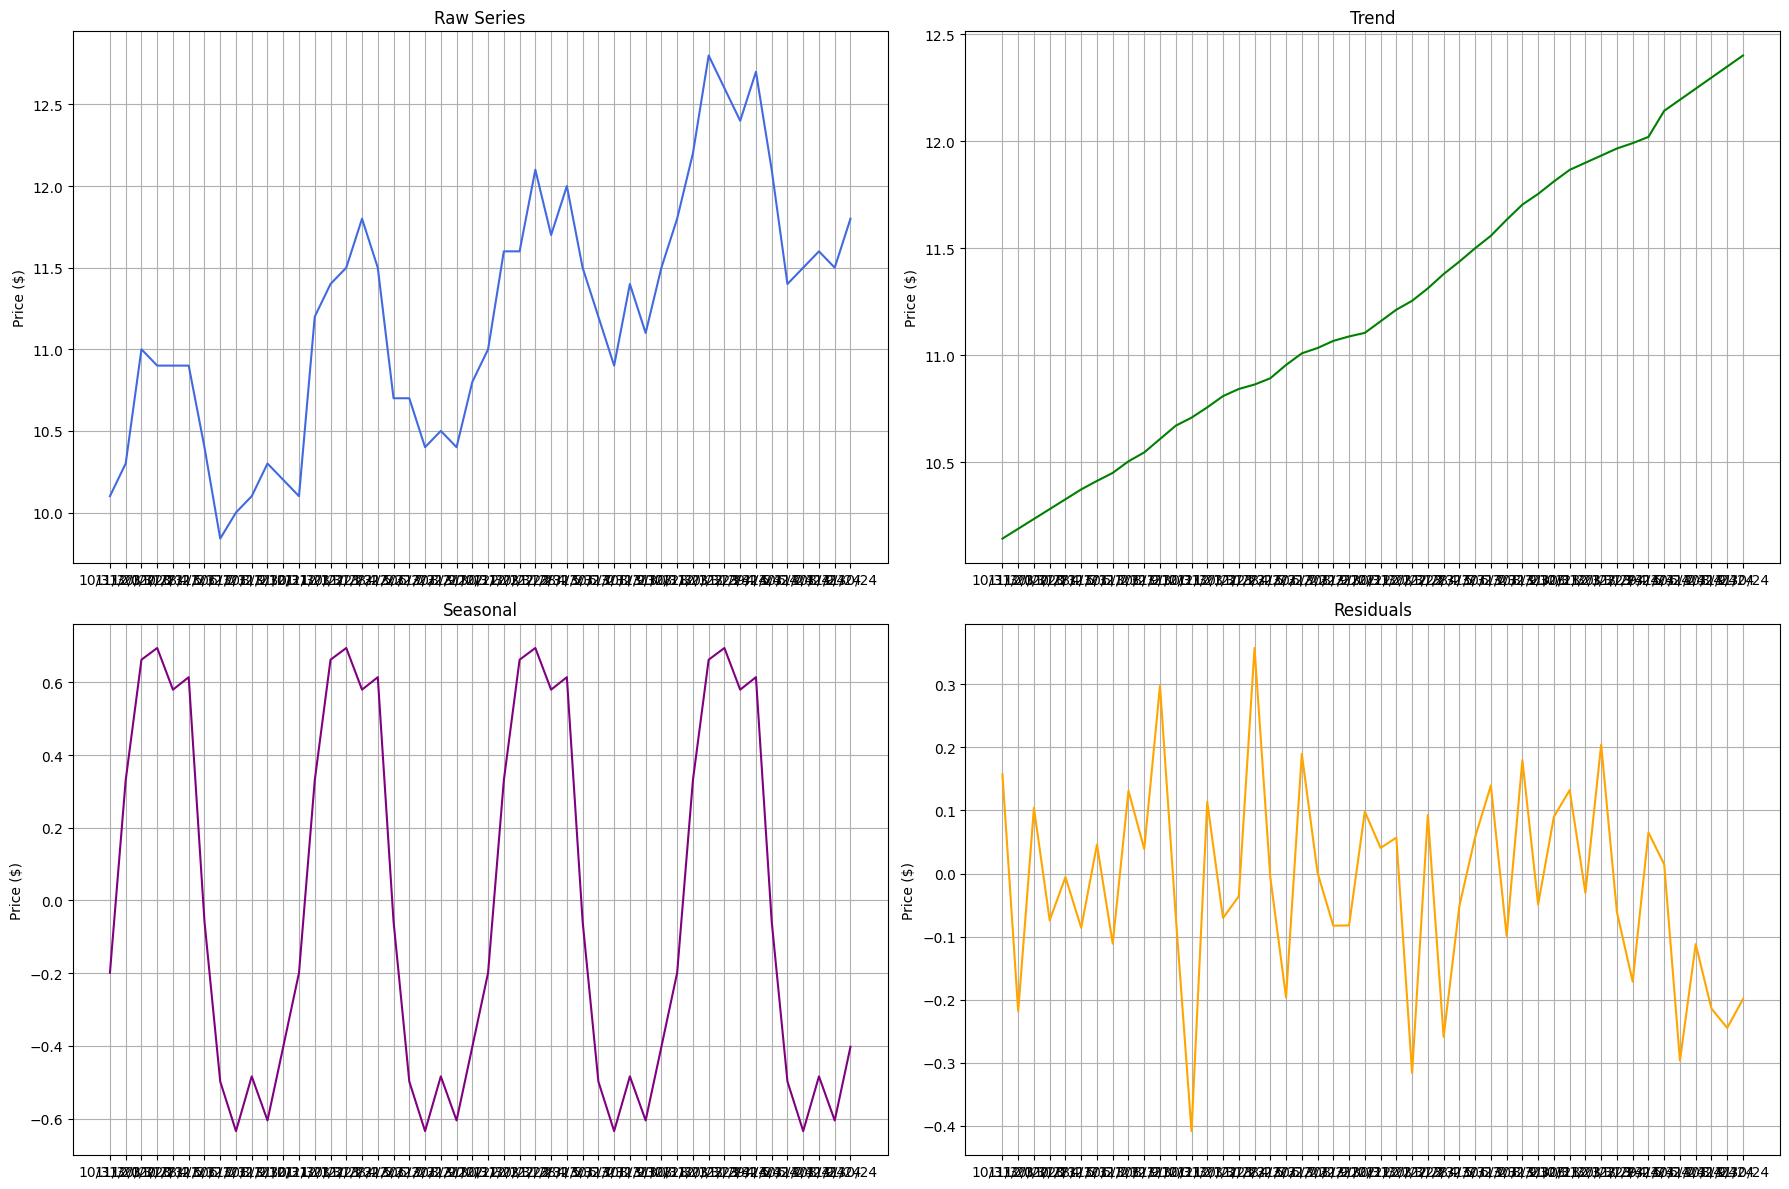

In [53]:
# Enhanced EDA plot
plt.figure(figsize=(18, 12))
components = [('Raw Series', data['Prices'], 'royalblue'),
            ('Trend', decomposition.trend, 'green'),
            ('Seasonal', decomposition.seasonal, 'purple'),
            ('Residuals', decomposition.resid, 'orange')]

for idx, (title, series, color) in enumerate(components, 1):
    plt.subplot(2, 2, idx)
    plt.plot(series, color=color)
    plt.title(title)
    plt.ylabel('Price ($)')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [54]:
# Ensure data.index is a proper DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)


<ipython-input-54-d91028613fdb>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = pd.to_datetime(data.index)


## Extended Exploratory Data Analysis (EDA)

The `full_eda_visualization` function creates a comprehensive visualization dashboard with four key components:

#### 1. Monthly Distribution Boxplot
- Shows price distribution by month  
- Helps identify seasonal patterns  

#### 2. Year-over-Year Comparison
- Compares price trajectories across different years  
- Highlights long-term trends and patterns  

#### 3. Autocorrelation Analysis
- Examines price correlation across different time lags  
- Identifies cyclical patterns  

#### 4. Rolling Statistics
- Displays 6-month moving average and standard deviation  
- Shows price volatility over time  


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

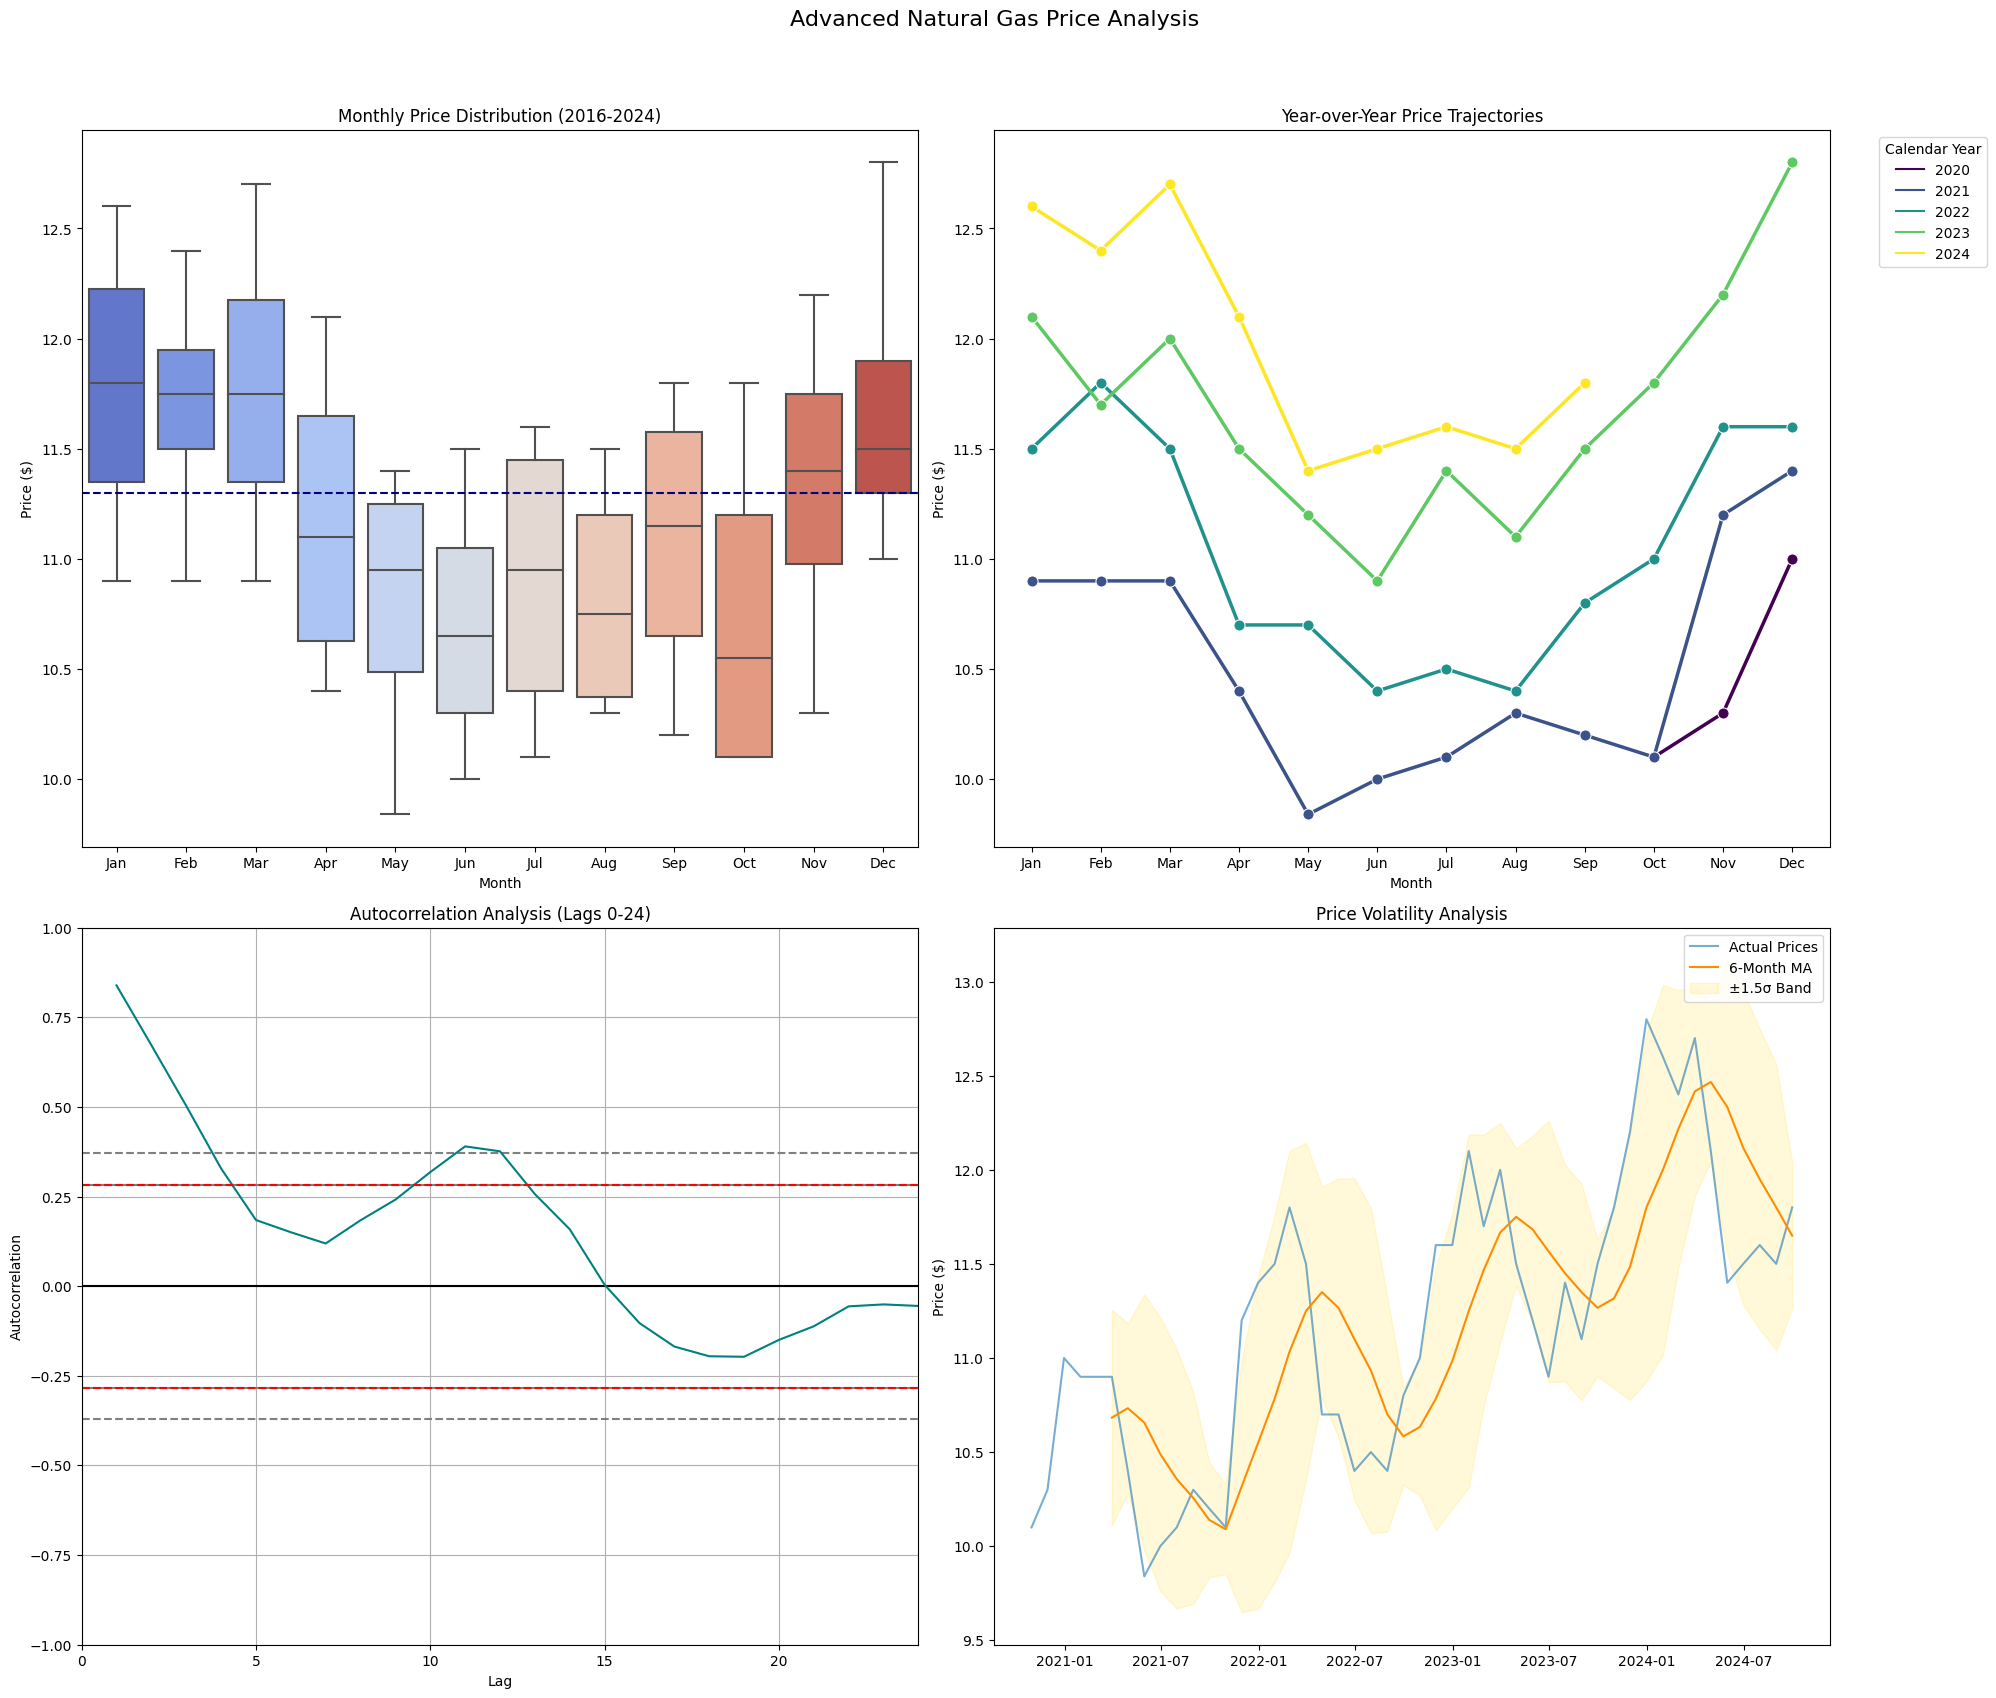

In [55]:
#%% [Extended EDA Visualizations]
def full_eda_visualization(data: pd.DataFrame):
    """Comprehensive EDA for time series data"""
    plt.figure(figsize=(20, 24))
    plt.suptitle('Advanced Natural Gas Price Analysis', y=1.02, fontsize=16)

    # --- 1. Monthly Distribution Boxplot ---
    ax1 = plt.subplot(3, 2, 1)
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    sns.boxplot(x=data.index.month_name().str[:3], 
              y=data['Prices'], 
              order=month_order,
              palette='coolwarm',
              showfliers=False)
    plt.title('Monthly Price Distribution (2016-2024)')
    plt.xlabel('Month')
    plt.ylabel('Price ($)')
    plt.axhline(data['Prices'].median(), color='navy', linestyle='--')

    # --- 2. Year-over-Year Comparison ---
    ax2 = plt.subplot(3, 2, 2)
    data['Year'] = data.index.year
    sns.lineplot(data=data, 
               x=data.index.month, 
               y='Prices', 
               hue='Year',
               palette='viridis',
               marker='o',
               markersize=8,
               linewidth=2.5)
    plt.title('Year-over-Year Price Trajectories')
    plt.xlabel('Month')
    plt.xticks(range(1,13), month_order)
    plt.ylabel('Price ($)')
    plt.legend(title='Calendar Year', bbox_to_anchor=(1.05, 1), loc='upper left')

    # --- 3. Correlation Analysis ---
    ax3 = plt.subplot(3, 2, 3)
    pd.plotting.autocorrelation_plot(data['Prices'], color='teal')
    plt.title('Autocorrelation Analysis (Lags 0-24)')
    plt.xlim(0, 24)  # Focus on 2-year business cycles
    plt.axhline(1.96/np.sqrt(len(data)), color='red', linestyle='--')  # 95% CI
    plt.axhline(-1.96/np.sqrt(len(data)), color='red', linestyle='--')

    # --- 4. Rolling Statistics ---
    ax4 = plt.subplot(3, 2, 4)
    rolling_window = 6  # Half-year window
    rolling_mean = data['Prices'].rolling(rolling_window).mean()
    rolling_std = data['Prices'].rolling(rolling_window).std()
    
    plt.plot(data['Prices'], label='Actual Prices', alpha=0.6)
    plt.plot(rolling_mean, label=f'{rolling_window}-Month MA', color='darkorange')
    plt.fill_between(data.index, 
                   rolling_mean - 1.5*rolling_std, 
                   rolling_mean + 1.5*rolling_std,
                   color='gold', alpha=0.15, label='±1.5σ Band')
    plt.title('Price Volatility Analysis')
    plt.ylabel('Price ($)')
    plt.legend()


    plt.tight_layout()
    plt.show()

# Execute full EDA
full_eda_visualization(data)

## Stationarity Analysis
The code performs extensive stationarity testing using the Augmented Dickey-Fuller (ADF) test:


Stationarity Diagnostics
ADF Test: Original Series
ADF Test Statistic       0.218077
p-value                  0.973257
#Lags Used              10.000000
Observations Used       37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400


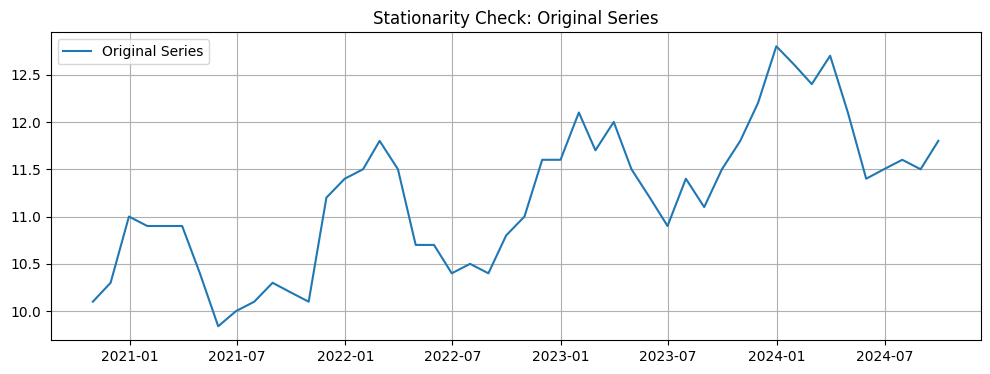

ADF Test: First Difference
ADF Test Statistic     -6.844774e+00
p-value                 1.754170e-09
#Lags Used              9.000000e+00
Observations Used       3.700000e+01
Critical Value (1%)    -3.620918e+00
Critical Value (5%)    -2.943539e+00
Critical Value (10%)   -2.610400e+00


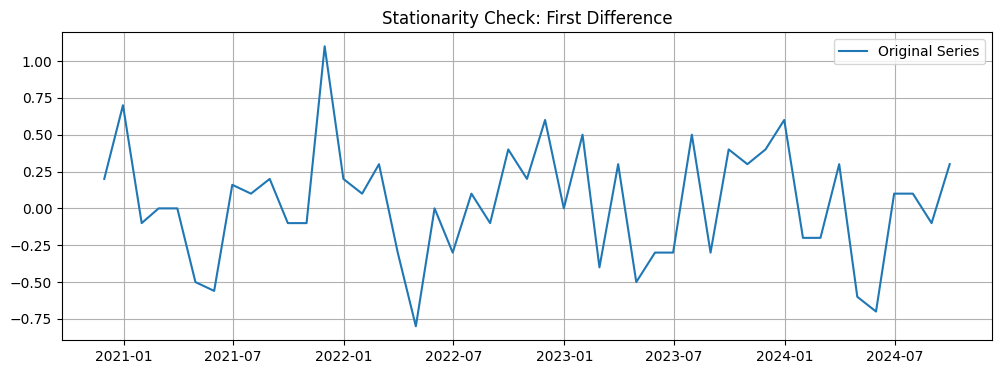

ADF Test: Seasonal Difference (12)
ADF Test Statistic     -6.338338e+00
p-value                 2.794531e-08
#Lags Used              0.000000e+00
Observations Used       3.500000e+01
Critical Value (1%)    -3.632743e+00
Critical Value (5%)    -2.948510e+00
Critical Value (10%)   -2.613017e+00


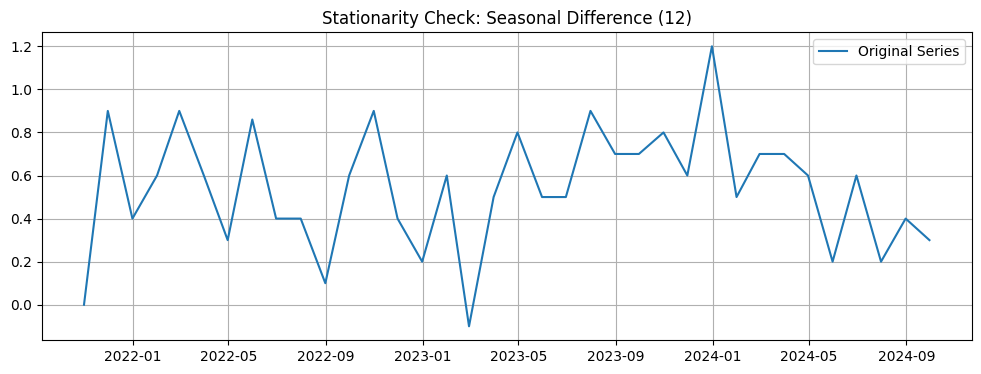

ADF Test: Combined (d=1, D=12)
ADF Test Statistic     -8.067866e+00
p-value                 1.578393e-12
#Lags Used              1.000000e+00
Observations Used       3.300000e+01
Critical Value (1%)    -3.646135e+00
Critical Value (5%)    -2.954127e+00
Critical Value (10%)   -2.615968e+00


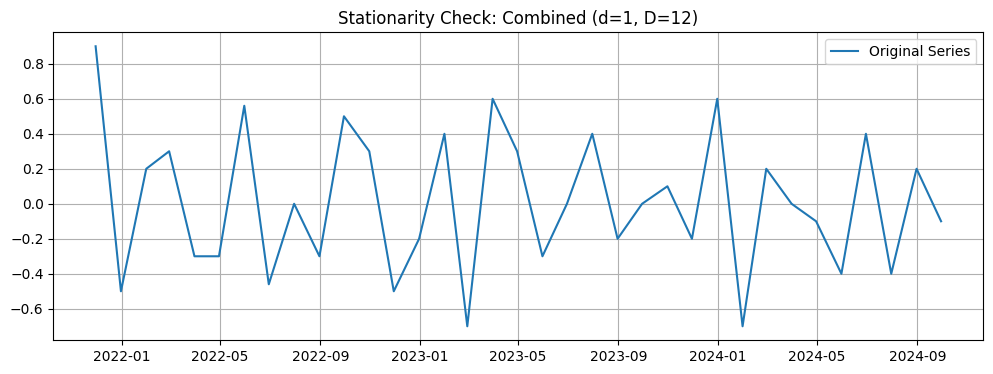


Recommended Differencing: d=1, D=1


In [56]:
#%% [Stationarity Analysis]
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """Enhanced ADF Test with visualization"""
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic','p-value','#Lags Used','Observations Used']
    out = pd.Series(result[0:4], index=labels)
    
    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    
    print(f'ADF Test: {title}')
    print(out.to_string())  # Better formatted output
    
    # Visualization
    plt.figure(figsize=(12,4))
    plt.plot(series, label='Original Series')
    plt.title(f'Stationarity Check: {title}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return result[1]  # Return p-value

#%% [Run Stationarity Checks]
print("\n" + "="*40)
print("Stationarity Diagnostics")
print("="*40)

# Original Series
p_value_orig = adf_test(data['Prices'], 'Original Series')

# First Difference
p_value_diff1 = adf_test(data['Prices'].diff().dropna(), 'First Difference')

# Seasonal Difference (12 months)
p_value_seasonal = adf_test(data['Prices'].diff(12).dropna(), 'Seasonal Difference (12)')

# Combined Differencing
combined_diff = data['Prices'].diff().diff(12).dropna()
p_value_combined = adf_test(combined_diff, 'Combined (d=1, D=12)')

# Auto-determine differencing based on ADF
if p_value_combined < 0.05:
    final_d = 1
    final_D = 1
elif p_value_seasonal < 0.05:
    final_d = 0
    final_D = 1
else:
    final_d = 1
    final_D = 0

print(f"\nRecommended Differencing: d={final_d}, D={final_D}")

In [57]:
# Force-diagnose stationarity (ADF Test)
# from statsmodels.tsa.stattools import adfuller

# def adf_test(series):
#     result = adfuller(series.dropna())
#     print(f'ADF Statistic: {result[0]:.3f}')
#     print(f'p-value: {result[1]:.3f}')
#     print(f'Stationary: {"Yes" if result[1] < 0.05 else "No"}')

# print("Original Series:")
# adf_test(data['Prices']) 

Tests are conducted on:
* Original series
* First difference (d=1)
* Seasonal difference (D=12)
* Combined differencing (d=1, D=12)

## ARIMA Modeling
The analysis uses auto_arima to automatically identify the optimal SARIMA model:

In [58]:
# Explicitly extract the target series
price_series = data['Prices']  

model = auto_arima(data['Prices'],
                   seasonal=True,
                   m=12,            # Annual seasonality
                   d=1,             # First-order differencing (fix trend)
                   D=1,             # Seasonal differencing (fix seasonality)
                   start_p=0, start_q=0,
                   max_order=5,     # Prevent overfitting
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True)      # Show model search process

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=36.460, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21.605, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25.917, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=34.778, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15.104, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=19.665, Time=0.06 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8.260, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(

Key model parameters:
* Seasonal period (m=12)
* First-order differencing (d=1)
* Seasonal differencing (D=1)
* Maximum order of 5 to prevent overfitting

In [59]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                   0.870
Date:                            Sun, 09 Feb 2025   AIC                              8.260
Time:                                    00:58:19   BIC                             16.037
Sample:                                10-31-2020   HQIC                            10.944
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7655      0.185     -4.148      0.000      -1.127      -0.404
ar.L2         -0.4605      0.173   

In [60]:
model.predict() 

2024-10-31    11.660029
2024-11-30    12.574428
2024-12-31    12.922069
2025-01-31    12.937279
2025-02-28    13.110291
2025-03-31    12.973205
2025-04-30    12.207110
2025-05-31    12.066503
2025-06-30    11.846020
2025-07-31    11.959727
Freq: ME, dtype: float64

## Results and Forecasting
The best model identified is SARIMAX(2,1,0)(2,1,0)[12] with:
* AIC: 8.260
* BIC: 16.037
* Log Likelihood: 0.870

The model generates 12-month forecasts with 95% confidence intervals, visualized using:

In [61]:
#%% [Forecasting & Visualization]
# Generate 12-month forecast
forecast, conf_int = model.predict(n_periods=12, return_conf_int=True)
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1),
                             periods=12, freq='ME')

# Create base DataFrames
historical_monthly = data.copy()
future_monthly = pd.DataFrame({'Prices': forecast}, index=forecast_dates)

#%% [Smart Interpolation]
def smart_interpolation(df, freq='D'):
    """Time-aware interpolation with edge preservation"""
    return (
        df.resample(freq)
        .asfreq()
        .interpolate(method='time', limit_area='inside')
        .ffill().bfill()  # Handle edge cases
    )

The code includes a smart interpolation function for handling daily price estimates. This allows for:
* Continuous daily price estimates
* Proper handling of gaps in the data
* Smooth transitions between actual and forecasted values

In [62]:
# Create continuous timeline
full_timeline = pd.date_range(start=data.index[0],
                            end=forecast_dates[-1],
                            freq='D')

In [63]:
# Create continuous timeline
full_timeline = pd.date_range(start=data.index[0],
                            end=forecast_dates[-1],
                            freq='D')

# Combine and interpolate
combined = pd.concat([historical_monthly, future_monthly])
daily_prices = smart_interpolation(combined)


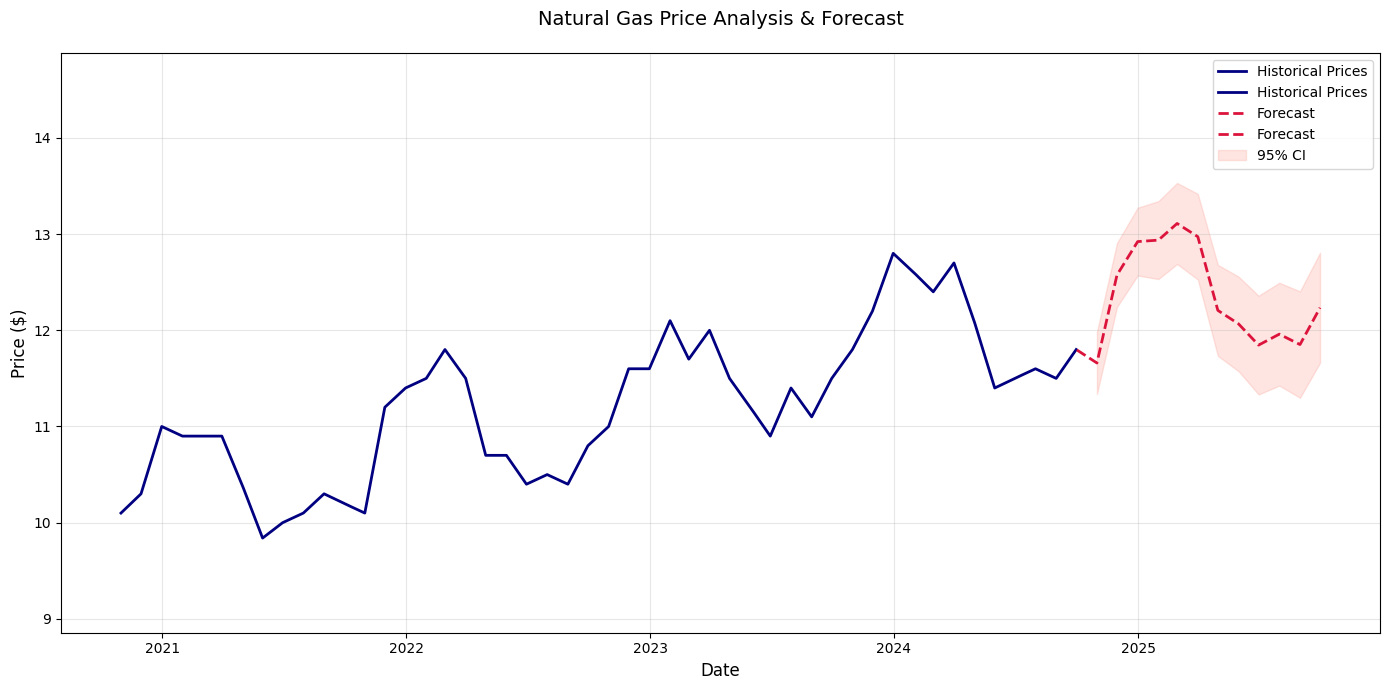

In [64]:
plt.figure(figsize=(14, 7))

# Get y-axis limits with some padding
y_min = min(data['Prices'].min(), conf_int[:,0].min()) * 0.9
y_max = max(data['Prices'].max(), conf_int[:,1].max()) * 1.1

# Plot with proper y-axis limits
plt.plot(daily_prices[:data.index[-1]], color='navy', label='Historical Prices', linewidth=2)
forecast_mask = daily_prices.index > data.index[-1]
plt.plot(daily_prices[forecast_mask], color='crimson', linestyle='--', label='Forecast', linewidth=2)
plt.fill_between(forecast_dates, conf_int[:,0], conf_int[:,1], color='salmon', alpha=0.2, label='95% CI')

# Set proper y-axis limits
plt.ylim(y_min, y_max)

# Improve formatting
plt.title('Natural Gas Price Analysis & Forecast', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()




## Price Estimation Function
The analysis concludes with a practical price estimation function:

In [65]:
#%% [Prediction Function]
def estimate_price(date_str):
    """Enhanced price estimation with error handling"""
    try:
        date = pd.to_datetime(date_str)
        if not pd.Timestamp(data.index[0]) <= date <= pd.Timestamp(forecast_dates[-1]):
            raise ValueError
        return round(daily_prices.loc[date, 'Prices'], 2)
    except Exception as e:
        date_range = f"{data.index[0].strftime('%Y-%m-%d')} to {forecast_dates[-1].strftime('%Y-%m-%d')}"
        return f"Error: Date must be between {date_range}"

# Example usage
print(estimate_price('2023-03-15'))  # Historical interpolation
print(estimate_price('2025-01-15'))  # Forecasted value

11.85
12.93


This function allows users to:
* Query prices for any date within the analysis period
* Get interpolated values for historical dates
* Get forecasted values for future dates
* Receive proper error handling for invalid dates

## Conclusions

The analysis reveals:

- Strong seasonal patterns in natural gas prices  
- Non-stationary behavior requiring both regular and seasonal differencing  
- Complex autoregressive patterns captured by the SARIMA model  
- Reliable short-term forecasting capabilities with quantified uncertainty  